### I. Import Required Dependecies

In [2]:
import os
import glob
from IPython.display import Image as IPImage
import pandas as pd             # Pandas
import numpy as np              # NumPy
import matplotlib.pyplot as plt # Matplotlib
import seaborn as sns           # Seaborn
from PIL import Image           # Pillow

# TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import DenseNet121


# Keras
from keras.layers import Flatten, Dense, Activation, Dropout
from keras import models, optimizers
from keras.models import Sequential
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from keras.regularizers import l2
from keras.layers import Conv2D, MaxPooling2D
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.applications import DenseNet121
from keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.utils import plot_model
from IPython.display import Image as IPImage


# scikit-learn
from sklearn.model_selection import train_test_split

### II. Read Dataset

**Directory Names Containing Training Data**

In [2]:
# Define the path to the directory containing the images for training
train_data = 'Dataset_BUSI_with_GT'

# Create a Pandas DataFrame with a single column
# The column is populated with the list of file/directory names in the 'train_data' directory
pd.DataFrame(
    os.listdir(train_data),
    columns=['File Name']
)

,File Name
0,benign
1,malignant
2,normal


**Directory Paths Containing Training Data**

In [3]:
# Get a list of the file paths in the 'train_data' directory
train_files = [i for i in glob.glob(train_data + "/*/*")]

# Randomly shuffle the list of file paths
np.random.shuffle(train_files)

# Extract labels from the directory names of each file path
labels = [os.path.dirname(i).split("/")[-1] for i in train_files]

# Combine file paths & its corresponding labels into a list of tuples
data = zip(train_files, labels)

# Create a Pandas DataFrame with 2 columns
# "Path" column contains file paths, & "Label" column contains corresponding labels
training_data = pd.DataFrame(data, columns=["Path", "Label"])

# Display the contents of the DataFrame
training_data

,Path,Label
0,Dataset_BUSI_with_GT\benign\benign (20).png,Dataset_BUSI_with_GT\benign
1,Dataset_BUSI_with_GT\malignant\malignant (74)_...,Dataset_BUSI_with_GT\malignant
2,Dataset_BUSI_with_GT\normal\normal (5)_mask.png,Dataset_BUSI_with_GT\normal
3,Dataset_BUSI_with_GT\normal\normal (86).png,Dataset_BUSI_with_GT\normal
4,Dataset_BUSI_with_GT\normal\normal (43).png,Dataset_BUSI_with_GT\normal
...,...,...
1573,Dataset_BUSI_with_GT\benign\benign (241).png,Dataset_BUSI_with_GT\benign
1574,Dataset_BUSI_with_GT\normal\normal (114).png,Dataset_BUSI_with_GT\normal
1575,Dataset_BUSI_with_GT\benign\benign (122).png,Dataset_BUSI_with_GT\benign
1576,Dataset_BUSI_with_GT\benign\benign (420)_mask.png,Dataset_BUSI_with_GT\benign


### III. Data Visualization

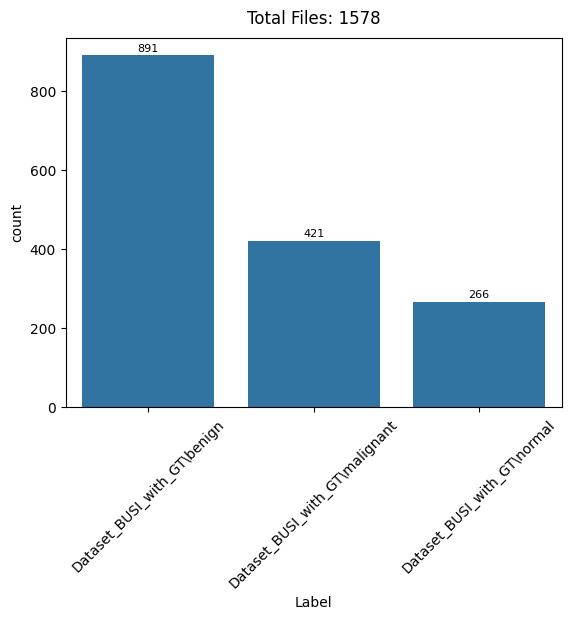

In [4]:
# Create a countplot() using Seaborn, where x-axis represents the "Label" column of the training_data DataFrame
ax = sns.countplot(x=training_data["Label"])

# Display count inside each bar as integers
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 5), textcoords='offset points', fontsize=8)

# Rotate x-axis labels for better visibility
plt.xticks(rotation=45)

# Add a title with the total count of files
plt.title(f'Total Files: {len(training_data)}', pad=10)

# Show the plot
plt.show()

### IV. Collect Data Paths & Labels from Directory Structure

In [5]:
data_paths = []
labels = []

main_dirs = os.listdir(train_data)
for folder_name in main_dirs:
    folder_path = os.path.join(train_data, folder_name)
    files = os.listdir(folder_path)
    for file in files:
        file_path = os.path.join(folder_path, file)
        data_paths.append(file_path)
        labels.append(folder_name)

### V. Data Preprocessing

In [6]:
# Set the batch size for training
batch_size = 16

# Define the target image size for preprocessing
image_size = (256, 256)

# Specify the number of color channels in the images (3 for RGB)
num_channels = 3

# Create the image shape tuple based on the specified size and channels
image_shape = (image_size[0], image_size[1], num_channels)

# Create a Pandas Series containing file paths with the name 'Path'
data_dirs = pd.Series(data_paths, name='Path')

# Create a Pandas Series containing corresponding labels with the name 'Label'
classes = pd.Series(labels, name='Label')

def preprocess_image(img):
    return img

# Split the data into training and validation-test sets
print(f"Training data shape: {training_data.shape}")
print(training_data.head())

train_df, val_test_df = train_test_split(
    training_data, 
    train_size=0.8, 
    shuffle=True, 
    random_state=123
)

# Further split the validation-test set into validation and test sets
val_df, test_df = train_test_split(
    val_test_df, 
    train_size=0.5, 
    shuffle=True, 
    random_state=123
)

# ImageDataGenerator configuration
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_image, 
    rescale=1.0/255
)

# Convert the 'Label' column to string type
train_df['Label'] = train_df['Label'].astype(str)
val_df['Label'] = val_df['Label'].astype(str)

# Create generators for training, validation, and testing
train_generator = datagen.flow_from_dataframe(
    train_df, 
    x_col='Path', 
    y_col='Label',
    target_size=image_size, 
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=True, 
    batch_size=batch_size
)

valid_generator = datagen.flow_from_dataframe(
    val_df, 
    x_col='Path', 
    y_col='Label',
    target_size=image_size, 
    class_mode='categorical',
    color_mode='rgb', 
    shuffle=True, 
    batch_size=batch_size
)

Training data shape: (1578, 2)
                                                Path  \
0        Dataset_BUSI_with_GT\benign\benign (20).png   
1  Dataset_BUSI_with_GT\malignant\malignant (74)_...   
2    Dataset_BUSI_with_GT\normal\normal (5)_mask.png   
3        Dataset_BUSI_with_GT\normal\normal (86).png   
4        Dataset_BUSI_with_GT\normal\normal (43).png   

                            Label  
0     Dataset_BUSI_with_GT\benign  
1  Dataset_BUSI_with_GT\malignant  
2     Dataset_BUSI_with_GT\normal  
3     Dataset_BUSI_with_GT\normal  
4     Dataset_BUSI_with_GT\normal  
Found 1262 validated image filenames belonging to 3 classes.
Found 158 validated image filenames belonging to 3 classes.


**Display Class Names**

In [7]:
# Get the class indices (mapping of the class names to numerical indices) from the training generator
class_indices = train_generator.class_indices

# Display the keys (class names) from the class_indices dictionary
class_indices.keys()

dict_keys(['Dataset_BUSI_with_GT\\benign', 'Dataset_BUSI_with_GT\\malignant', 'Dataset_BUSI_with_GT\\normal'])

In [8]:
# Initialize an empty list to store class labels
labels = []

# Iterate through the keys (class names) in the class_indices dictionary
for key in class_indices.keys():
    labels.append(key)  # Append each class name to the labels list

# Calculate the total no. of unique labels
total_labels = len(labels)

# Print the list of class labels and the total no. of unique labels
print("Labels: ", labels)
print("\nTotal no. of unique labels:", total_labels)

Labels:  ['Dataset_BUSI_with_GT\\benign', 'Dataset_BUSI_with_GT\\malignant', 'Dataset_BUSI_with_GT\\normal']

Total no. of unique labels: 3


**Visualize a Subset of Images from the Training Set**

(473, 319, 3)
(464, 558)
(573, 765, 3)
(469, 552, 3)
(592, 759, 3)
(578, 766, 3)
(461, 646)
(497, 622, 3)


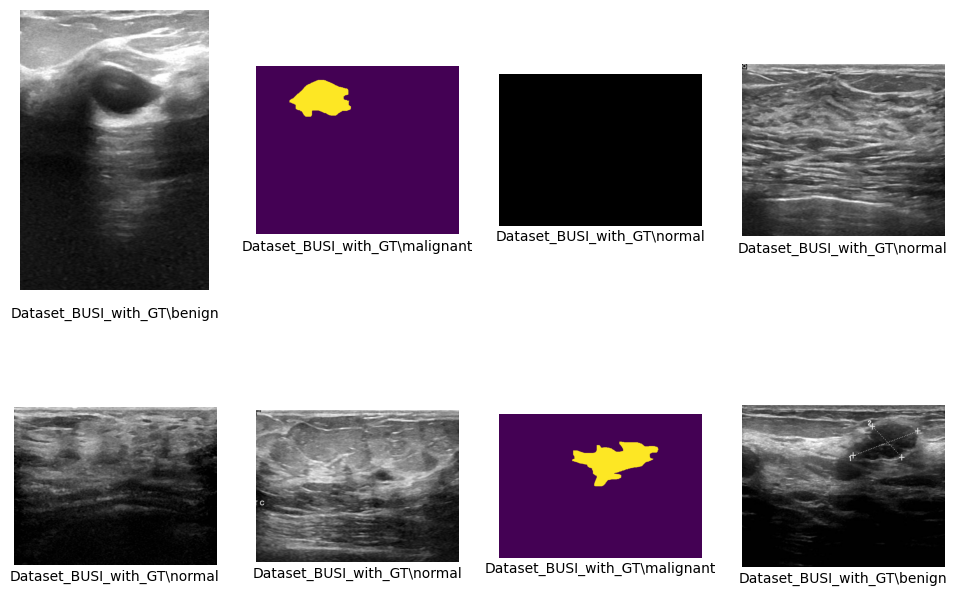

In [9]:
# Set the number of rows and columns for the subplot grid
no_of_rows = 2
no_of_columns = 4

# Create a subplot grid with the specified number of rows and columns
fig, axes = plt.subplots(no_of_rows, no_of_columns, figsize=(12, 8))

# Iterate through the rows
for i in range(no_of_rows):
    # Iterate through the columns
    for j in range(no_of_columns):
        # Calculate the index for accessing the data
        index = i * no_of_columns + j

        # Check if the index is within the bounds of the data
        if index < len(training_data):

            # Open the image using the PIL library
            im = Image.open(training_data.iloc[index]['Path'])

            # Convert the PIL image to a NumPy array
            img = np.array(im)

            # Print the shape of the image array
            print(img.shape)

            # Display the image on the subplot at position (i, j)
            axes[i, j].imshow(img)

            # Turn off axis labels for better visualization
            axes[i, j].axis('off')

            # Get the label for the current image and display it as text
            label = training_data.iloc[index]['Label']
            axes[i, j].text(0.5, -0.1, label, ha='center', transform=axes[i, j].transAxes)

# Show the entire subplot grid
plt.show()

### VI. Build Model

In [3]:
# Load DenseNet-121 with pre-trained weights
base_model = DenseNet121(
    weights='imagenet',
    include_top=False, 
    input_shape=(256, 256, 3)
)

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Create model
model = Sequential()

# Add the pre-trained DenseNet-121 base model
model.add(base_model)

# Flatten the output of the base model
model.add(Flatten())

# Add fully connected layers with dropout for regularization
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))

# Additional layers for classification
model.add(Dense(128, activation='relu'))
model.add(Dense(3, activation='softmax'))

# Display the summary of the model architecture
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 8, 8, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    67,109,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,787,843 (289.11 MB)

 Trainable params: 68,750,339 (262.26 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

**Visualize the Neural Network Architecture**

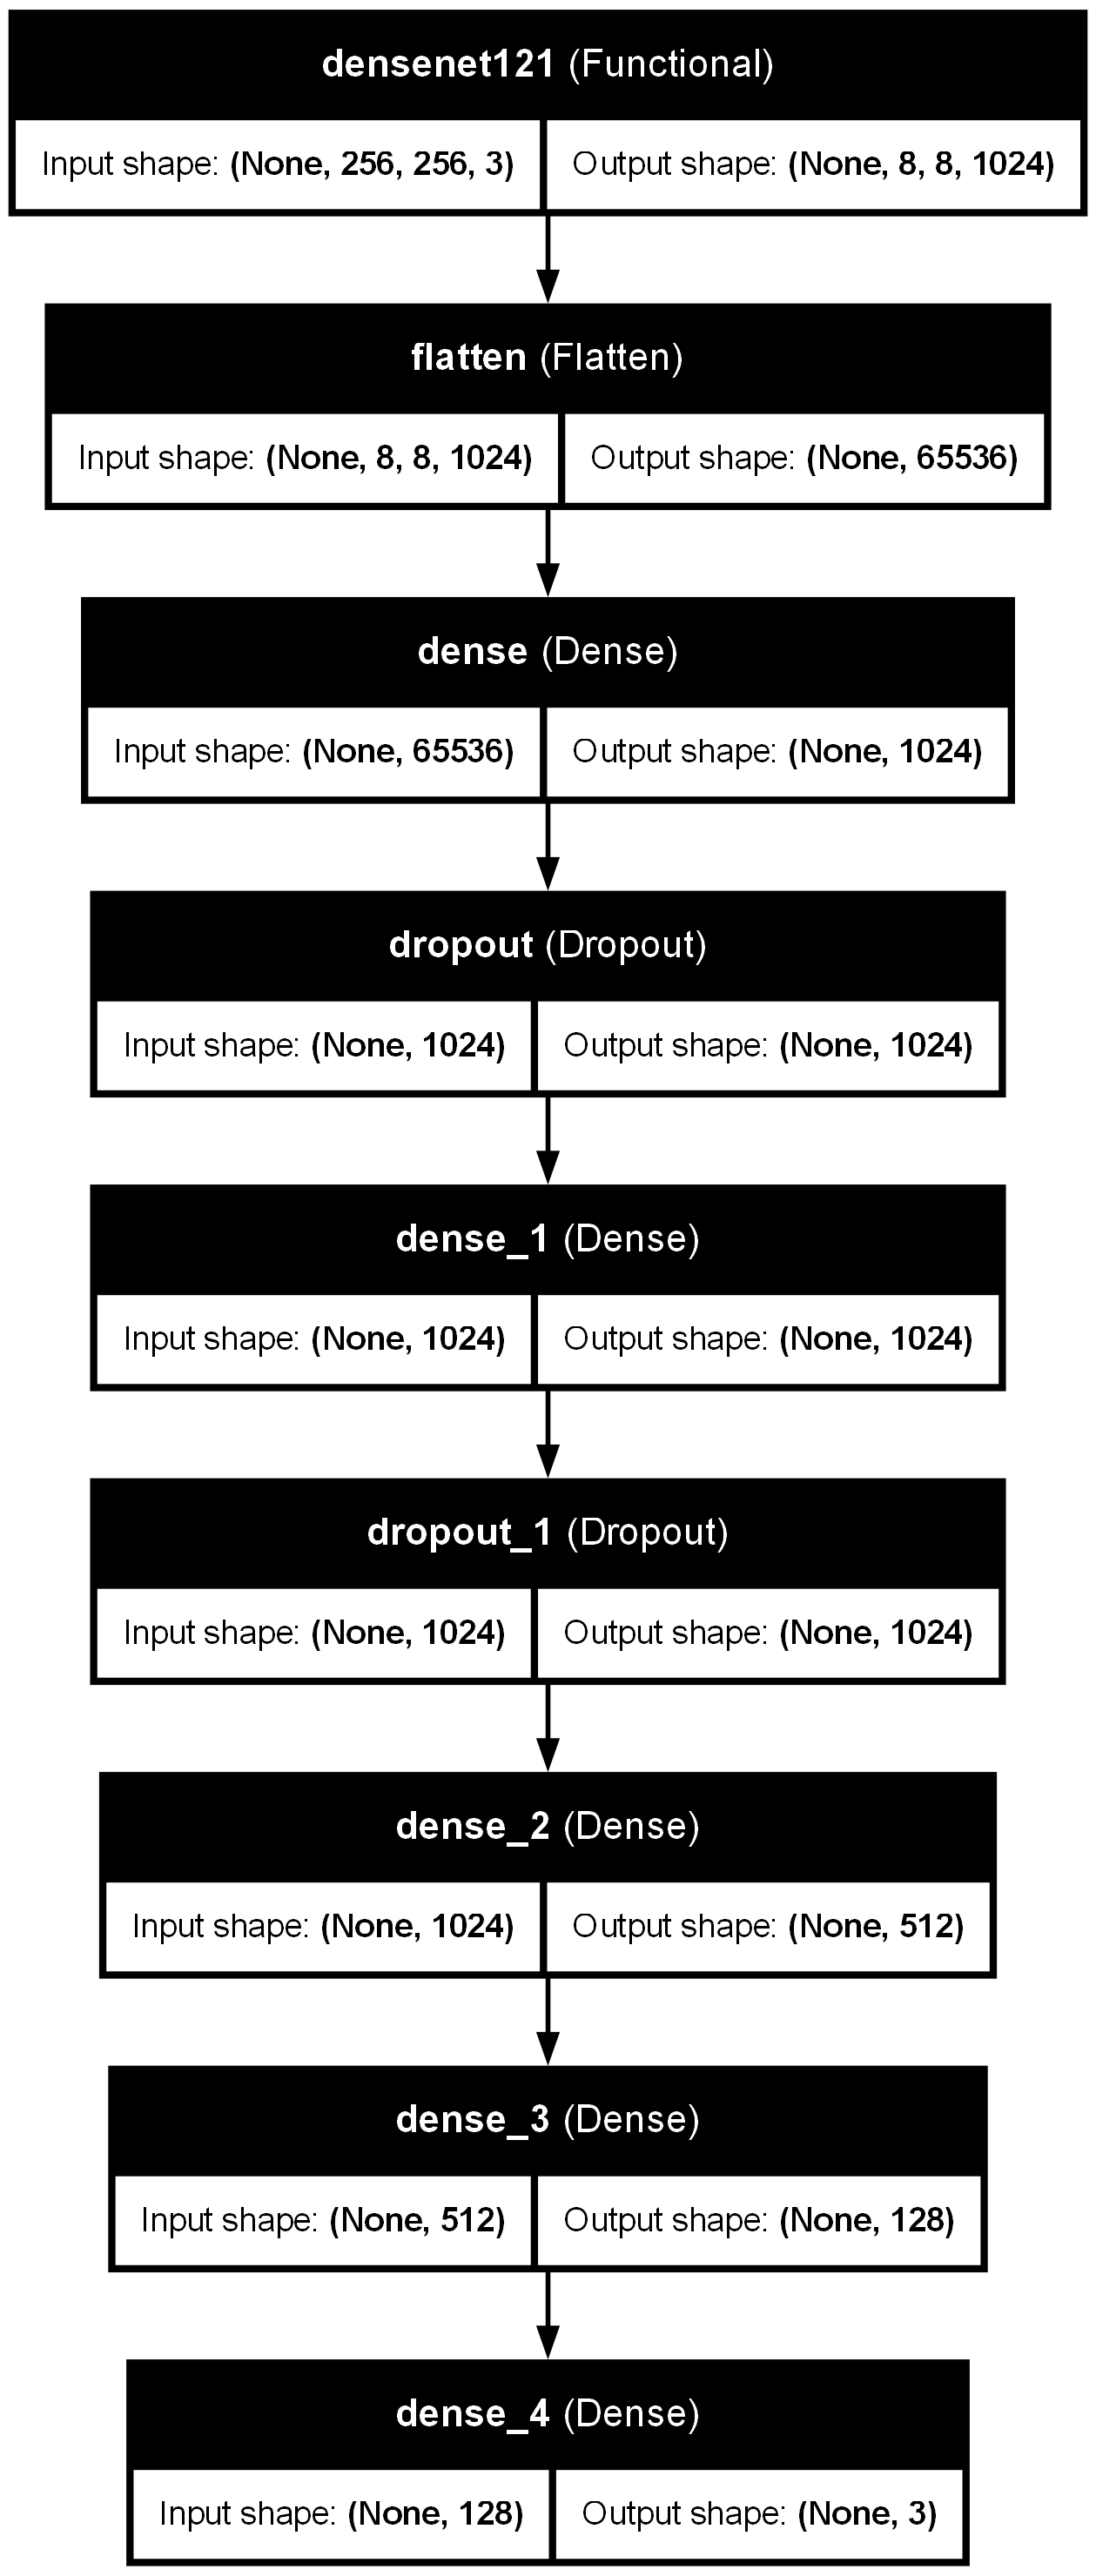

In [11]:
# Specify the file path for saving the visualization image
model_visualization_path = "visualization_image.png"

# Plot the model and save the visualization image
plot_model(model, to_file=model_visualization_path, show_shapes=True, show_layer_names=True)

# Display the visualization image
IPImage(filename=model_visualization_path)

**Create Model Checkpoint Callback to Save Best Model**

In [12]:
# Define the path to save the best model checkpoint
checkpoint_path = "model.h5"

# Create a ModelCheckpoint callback
# This callback saves the model when validation accuracy improves
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_accuracy',  # Monitor validation accuracy
    save_best_only=True,     # Save only the best model
    mode='max',              # Save based on the maximum validation accuracy
    verbose=1                # Display progress information
)                

### VII. Compile Model

In [13]:
# Compile the model with the Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Categorical crossentropy loss for multi-class classification
    metrics=['accuracy']              # Monitor accuracy during training
)              

### VIII. Train Model

In [14]:
# Train the model using the fit() method
history = model.fit(
    train_generator,                                   # Training data generator
    steps_per_epoch=train_generator.samples // train_generator.batch_size,  # Number of steps per epoch
    epochs=10,                                         # Number of training epochs
    validation_data=valid_generator,                   # Validation data generator
    validation_steps=valid_generator.samples // valid_generator.batch_size,  # Number of validation steps
    callbacks=[checkpoint]                             # List of callbacks, including the ModelCheckpoint
)
model.save("final_model.h5")


C:\Users\Ojeshwi\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4693 - loss: 1.0731
Epoch 1: val_accuracy improved from -inf to 0.67361, saving model to model.h5


78/78 ━━━━━━━━━━━━━━━━━━━━ 235s 3s/step - accuracy: 0.4702 - loss: 1.0719 - val_accuracy: 0.6736 - val_loss: 0.8274
Epoch 2/10
 1/78 ━━━━━━━━━━━━━━━━━━━━ 3:51 3s/step - accuracy: 0.7500 - loss: 0.6820

C:\Users\Ojeshwi\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.67361 to 0.68056, saving model to model.h5


78/78 ━━━━━━━━━━━━━━━━━━━━ 24s 276ms/step - accuracy: 0.7500 - loss: 0.6820 - val_accuracy: 0.6806 - val_loss: 0.8466
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6785 - loss: 0.8319
Epoch 3: val_accuracy improved from 0.68056 to 0.69444, saving model to model.h5


78/78 ━━━━━━━━━━━━━━━━━━━━ 171s 2s/step - accuracy: 0.6780 - loss: 0.8319 - val_accuracy: 0.6944 - val_loss: 0.7271
Epoch 4/10
 1/78 ━━━━━━━━━━━━━━━━━━━━ 3:20 3s/step - accuracy: 0.5625 - loss: 0.8593
Epoch 4: val_accuracy improved from 0.69444 to 0.70833, saving model to model.h5


78/78 ━━━━━━━━━━━━━━━━━━━━ 25s 292ms/step - accuracy: 0.5625 - loss: 0.8593 - val_accuracy: 0.7083 - val_loss: 0.6828
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6839 - loss: 0.7298
Epoch 5: val_accuracy did not improve from 0.70833
78/78 ━━━━━━━━━━━━━━━━━━━━ 204s 3s/step - accuracy: 0.6836 - loss: 0.7300 - val_accuracy: 0.6944 - val_loss: 0.6539
Epoch 6/10
 1/78 ━━━━━━━━━━━━━━━━━━━━ 2:56 2s/step - accuracy: 0.5625 - loss: 0.8415
Epoch 6: val_accuracy did not improve from 0.70833
78/78 ━━━━━━━━━━━━━━━━━━━━ 18s 206ms/step - accuracy: 0.5625 - loss: 0.8415 - val_accuracy: 0.7014 - val_loss: 0.6681
Epoch 7/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6922 - loss: 0.6793
Epoch 7: val_accuracy did not improve from 0.70833
78/78 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.6919 - loss: 0.6798 - val_accuracy: 0.6875 - val_loss: 0.6782
Epoch 8/10
 1/78 ━━━━━━━━━━━━━━━━━━━━ 2:37 2s/step - accuracy: 0.6875 - loss: 0.7999
Epoch 8: val_accuracy did not improve from 

**Display Training History**

In [15]:
# Create a Pandas DataFrame containing the training history (metrics) of the model
train_history = pd.DataFrame(history.history)

# Add a new column 'Epoch' with values from 1 to the number of epochs
train_history['Epoch'] = range(1, len(train_history) + 1)

# Reorder columns for clarity
train_history = train_history[['Epoch', 'loss', 'accuracy', 'val_loss', 'val_accuracy']]

# Display the DataFrame
train_history

,Epoch,loss,accuracy,val_loss,val_accuracy
0,1,0.976652,0.543339,0.827367,0.673611
1,2,0.681963,0.750000,0.846596,0.680556
2,3,0.828040,0.638042,0.727065,0.694444
3,4,0.859256,0.562500,0.682791,0.708333
4,5,0.742034,0.660514,0.653898,0.694444
5,6,0.841464,0.562500,0.668115,0.701389
6,7,0.718839,0.666934,0.678200,0.687500
7,8,0.799854,0.687500,0.676011,0.694444
8,9,0.735511,0.661316,0.685459,0.680556
9,10,1.117818,0.437500,0.649782,0.708333


### IX. Evaluate Model (Train & Validation Set)

In [16]:
# Evaluate the model on the train set
train_loss, train_accuracy = model.evaluate(train_generator, steps=train_generator.samples // train_generator.batch_size)

# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(valid_generator, steps=valid_generator.samples // valid_generator.batch_size)

# Convert accuracy to percentage
train_accuracy_percentage = train_accuracy * 100
val_accuracy_percentage = val_accuracy * 100

# Create a Pandas DataFrame to display the results
evaluation_results = pd.DataFrame({
    'Set': ['Train', 'Validation'],
    'Loss': [train_loss, val_loss],
    'Accuracy': [f'{train_accuracy_percentage:.2f}%', f'{val_accuracy_percentage:.2f}%']
})

# Display the evaluation results DataFrame
evaluation_results

78/78 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.6934 - loss: 0.7007
9/9 ━━━━━━━━━━━━━━━━━━━━ 16s 2s/step - accuracy: 0.6710 - loss: 0.6548


,Set,Loss,Accuracy
0,Train,0.702244,67.79%
1,Validation,0.678912,68.06%


**Plot Loss & Accuracy**

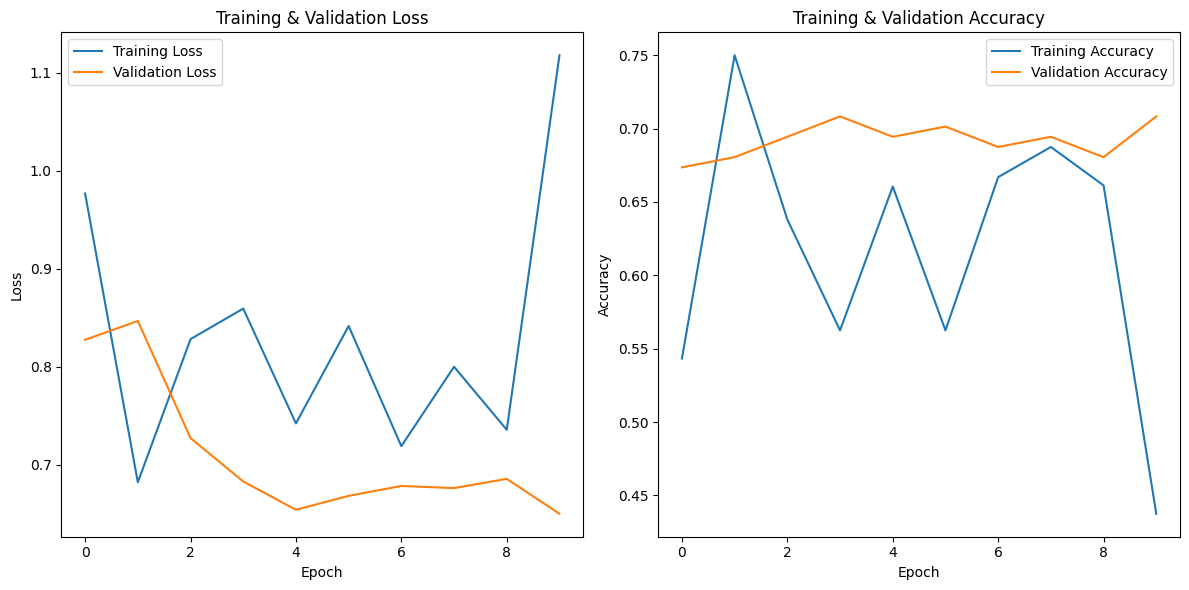

In [17]:
# Plotting the training and validation loss
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(train_history['loss'], label='Training Loss')
plt.plot(train_history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_history['accuracy'], label='Training Accuracy')
plt.plot(train_history['val_accuracy'], label='Validation Accuracy')
plt.title('Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()